In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [5]:
#random_seed 고정
import random

random_seed = 2

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
# paths for (labeled) training & validation data.
train_path = '/content/drive/MyDrive/FashionClassification/Train/'
valid_path = '/content/drive/MyDrive/FashionClassification/Validation/'

In [ ]:
# data augmentation
import random
import os
import cv2
import glob
from PIL import Image
import PIL.ImageOps    

#각 폴더 별 새로만들 이미지 개수 지정(총 2400*3장 생성)
num_augmented_images = 2400

file_path1 = '/content/drive/MyDrive/FashionClassification/Train/Sporty'
file_path2 = '/content/drive/MyDrive/FashionClassification/Train/Retro'
file_path3 = '/content/drive/MyDrive/FashionClassification/Train/Resort'
file_names1 = os.listdir(file_path1)
file_names2 = os.listdir(file_path2)
file_names3 = os.listdir(file_path3)

save_path1 = '/content/drive/MyDrive/FashionClassification/Train/Sporty/'
save_path2 = '/content/drive/MyDrive/FashionClassification/Train/Retro/'
save_path3 = '/content/drive/MyDrive/FashionClassification/Train/Resort/'
total_origin_image_num = len(file_names1)
augment_cnt = 1

for i in range(1, num_augmented_images):
    change_picture_index = random.randrange(1, total_origin_image_num-1)
    print(change_picture_index)
    #print(file_names[change_picture_index])
    file_name1 = file_names1[change_picture_index]
    file_name2 = file_names2[change_picture_index]
    file_name3 = file_names3[change_picture_index]

    origin_image_path1 = file_path1 +'/'+ file_name1
    origin_image_path2 = file_path2 + '/'+file_name2
    origin_image_path3 = file_path3 + '/'+file_name3

    #print(origin_image_path)
    image1 = Image.open(origin_image_path1)
    image2 = Image.open(origin_image_path2)
    image3 = Image.open(origin_image_path3)

    random_augment = random.randrange(1,3)
    
    if(random_augment == 1):
        #이미지 좌우 반전
        print("invert")
        inverted_image1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
        inverted_image2 = image2.transpose(Image.FLIP_LEFT_RIGHT)
        inverted_image3 = image3.transpose(Image.FLIP_LEFT_RIGHT)

        inverted_image1.save(save_path1 + 'inverted_' + str(augment_cnt) + '.png')
        inverted_image2.save(save_path2 + 'inverted_' + str(augment_cnt) + '.png')
        inverted_image3.save(save_path3 + 'inverted_' + str(augment_cnt) + '.png')

    elif(random_augment == 2):
        #이미지 기울이기
        print("rotate")
        rotated_image1 = image1.rotate(random.randrange(-30, 30))
        rotated_image2 = image2.rotate(random.randrange(-30, 30))
        rotated_image3 = image3.rotate(random.randrange(-30, 30))

        rotated_image1.save(save_path1 + 'rotated_' + str(augment_cnt) + '.png')
        rotated_image2.save(save_path2 + 'rotated_' + str(augment_cnt) + '.png')
        rotated_image3.save(save_path3 + 'rotated_' + str(augment_cnt) + '.png')

    augment_cnt += 1

In [ ]:
# prepare training data set
classes = ['Resort', 'Retro', 'Sporty']

data =[]
label =[]

Batch_Size = 64

## i : Integer representation for each classes (Resort/Retro/Sporty -> 0/1/2)
for i, d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f,'r')
        img = img.resize((224, 224))
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1))  # (224,224,3) --> (3,224,224)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)

In [ ]:
data.shape, label.shape  # check

((14397, 3, 224, 224), (14397,))

In [9]:
# prepare validation data set
classes = ['Resort', 'Retro', 'Sporty']
data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+'/'+d)
    
    for f in files:
        img = Image.open(valid_path+'/'+d+'/'+f,'r')
        img = img.resize((224, 224))
        img = np.asarray(np.float32(img))
        data.append(img.transpose(2,0,1)) 
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [10]:
data.shape, label.shape  # check

((1800, 3, 224, 224), (1800,))

In [14]:
# 1x1 convolution
def conv_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,1,1),
        nn.ReLU(),
    )
    return model

# 1x1 conv -> 3x3 convolution
def conv_1_3(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU()
    )
    return model

# 1x1 conv -> 5x5 convolution
def conv_1_5(in_dim,mid_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,mid_dim,1,1),
        nn.ReLU(),
        nn.Conv2d(mid_dim,out_dim,5,1,2),
        nn.ReLU()
    )
    return model

# 3x3 maxPooling -> 1x1 convolution
def max_3_1(in_dim, out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_dim, out_dim, 1,1),
        nn.ReLU(),
    )
    return model


#Inception Module
class inception_module(nn.Module):
    def __init__(self,in_dim,out_dim_1,mid_dim_3,out_dim_3,mid_dim_5,out_dim_5,pool_dim):
        super(inception_module,self).__init__()
        # 1x1 Convolution
        self.conv_1 = conv_1(in_dim,out_dim_1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1_3 = conv_1_3(in_dim,mid_dim_3,out_dim_3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1_5 = conv_1_5(in_dim,mid_dim_5,out_dim_5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.max_3_1 = max_3_1(in_dim,pool_dim)

    def forward(self,x):
        out_1 = self.conv_1(x)
        out_2 = self.conv_1_3(x)
        out_3 = self.conv_1_5(x)
        out_4 = self.max_3_1(x)
        # concat
        output = torch.cat([out_1,out_2,out_3,out_4],1)
        return output


In [15]:
# GoogleNet
class GoogLeNet(nn.Module):
    def __init__(self, base_dim=64, num_classes=3):
        super(GoogLeNet, self).__init__()
        self.num_classes=num_classes
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels= base_dim, kernel_size=7, stride = 2, padding = 3),
            nn.MaxPool2d(3,2,1),
            nn.Conv2d(in_channels = base_dim, out_channels=base_dim*3, kernel_size=3,stride =1,padding =1),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            inception_module(base_dim*3,64,96,128,16,32,32),
            inception_module(base_dim*4,128,128,192,32,96,64),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_3 = nn.Sequential(
            inception_module(480,192,96,208,16,48,64),
            inception_module(512,160,112,224,24,64,64),
            inception_module(512,128,128,256,24,64,64),
            inception_module(512,112,144,288,32,64,64),
            inception_module(528,256,160,320,32,128,128),
            nn.MaxPool2d(3,2,1),
        )
        self.layer_4 = nn.Sequential(
            inception_module(832,256,160,320,32,128,128),
            inception_module(832,384,192,384,48,128,128), # 7x7x1024
            nn.AvgPool2d(7,1), # 1x1x1024
        )
        self.layer_5 = nn.Dropout2d(0.4)
        self.fc_layer = nn.Linear(1024,self.num_classes)
                
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = out.view(out.shape[0],-1) 
        out = self.fc_layer(out)
        return out
  
model = GoogLeNet().to(DEVICE)  # 모델 GPU로
model # Print network

GoogLeNet(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): inception_module(
      (conv_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (conv_1_3): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (conv_1_5): Sequential(
        (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): ReLU()
      )
      (max_3_1): Sequential

In [16]:
from torchsummary import summary
summary(model, input_size=(3,224,224), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 192, 56, 56]         110,784
         MaxPool2d-4          [-1, 192, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          12,352
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 96, 28, 28]          18,528
              ReLU-8           [-1, 96, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]         110,720
             ReLU-10          [-1, 128, 28, 28]               0
           Conv2d-11           [-1, 16, 28, 28]           3,088
             ReLU-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]          12,832
             ReLU-14           [-1, 32,

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=5e-3)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        # print('Valid_Prediction : {}'.format(pred))
        # print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /100
Train Accuracy : 39.11926095714385
Validation Accuracy : 45.38888888888889
Train Loss : 243.02005445957184
Validation Loss : 30.57403063774109
# Epoch : 1 /100
Train Accuracy : 46.44023060359797
Validation Accuracy : 51.44444444444445
Train Loss : 232.8851541876793
Validation Loss : 28.887150943279266
# Epoch : 2 /100
Train Accuracy : 51.00368132249774
Validation Accuracy : 53.888888888888886
Train Loss : 222.38183963298798
Validation Loss : 27.76602178812027
# Epoch : 3 /100
Train Accuracy : 54.99062304646801
Validation Accuracy : 57.277777777777786
Train Loss : 213.10726195573807
Validation Loss : 26.498219549655914
# Epoch : 4 /100
Train Accuracy : 56.41453080502883
Validation Accuracy : 56.99999999999999
Train Loss : 208.09170377254486
Validation Loss : 26.035075962543488
# Epoch : 5 /100
Train Accuracy : 58.164895464332844
Validation Accuracy : 60.72222222222222
Train Loss : 200.88819366693497
Validation Loss : 25.202207386493683
# Epoch : 6 /100

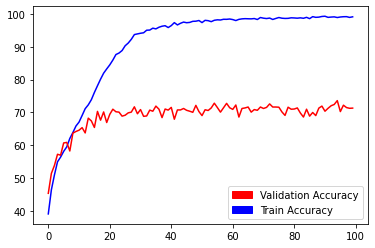

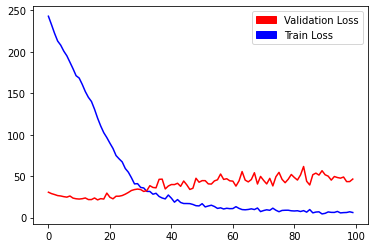

<All keys matched successfully>

In [ ]:
# Learning
import copy

acc_t = []
acc_v = []

loss_train = []
loss_val = []

print('***START EPOCH***')
best_acc = 0.0  # beset accuracy 초기화
best_model_wts = copy.deepcopy(model.state_dict()) 

for epoch in range(100):
    print('# Epoch : {} /100'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    print('Train Loss : {}'.format(loss_t))
    print('Validation Loss : {}'.format(loss_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)
    loss_train.append(loss_t)
    loss_val.append(loss_v)

    if accuracy_v>best_acc:  # update best accuracy
      best_acc = accuracy_v
      best_model_wts = copy.deepcopy(model.state_dict())  # 가장 accuracy 높은 model 저장

plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Loss Graph
plt.plot(range(len(loss_train)), loss_train, 'b', range(len(loss_val)), loss_val, 'r')
blue_patch = mpatches.Patch(color='blue', label='Train Loss')
red_patch = mpatches.Patch(color='red', label='Validation Loss')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

model.load_state_dict(best_model_wts) # validation accuracy, 가장 높은 모델 저장


In [ ]:
best_acc

73.61111111111111

In [ ]:
torch.save(model,'/content/drive/MyDrive/FashionClassification/Model_TeamB')

In [ ]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0      
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     
            output = model(data)                                  
            test_loss += criterion(output, target).item()         
            pred = output.max(1, keepdim=True)[1]                 
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy

In [ ]:
model=torch.load('/content/drive/MyDrive/FashionClassification/Model_TeamB')
#model.eval()
_, train_acc = evaluate(model, train_loader)
_, val_acc = evaluate(model, valid_loader)

# prit saved model's train and validation accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Validation Accuracy: {:.4f}'.format(val_acc))

Train Accuracy: 99.6735
Validation Accuracy: 73.6111


In [11]:
from sklearn.metrics import classification_report
def prediction(model, data_loader):
    model.eval()
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
      for i, (data, label) in enumerate(data_loader):
        data = data.to(DEVICE)        # 데이터 DEVICE에 할당
        label = label.to(DEVICE)      # 라벨 값 DEVICE에 할당
        outputs = model(data)         # 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        
    # Classification Report
    print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
    return

In [ ]:
prediction(model, valid_loader)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       600
           1       0.77      0.78      0.77       600
           2       0.74      0.75      0.75       600

    accuracy                           0.74      1800
   macro avg       0.74      0.74      0.74      1800
weighted avg       0.74      0.74      0.74      1800

